# Explor Multivalue LSMTree

In [1]:
import os.path
import json
import re
from glob import glob
from collections import defaultdict
from functools import reduce, partial
import operator

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from cycler import cycler
import pandas as pd
import seaborn as sns
import csaps
from tqdm import tqdm
from tdigest import TDigest

from tdigest_java import read_tdigest

tqdm.pandas()

plt.style.use(['fivethirtyeight'])
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 400)
pd.set_option('display.max_colwidth', 100)

colors = ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c', '#cc6600', '#cc3399', '#00cc66']
plt.rcParams['axes.prop_cycle'] = cycler(color=colors)

# Constants

In [2]:
type(plt.rcParams['axes.prop_cycle'])

cycler.Cycler

In [3]:
background_color = '#fcfcfc'
old_background_color = plt.rcParams['axes.edgecolor']
for k,v in plt.rcParams.items():
    if v == old_background_color:
        plt.rcParams[k] = background_color

In [4]:
results_base_dir = 'results/mv_doc'
!ls $results_base_dir

author_count.txt  file_sizes.csv  get  load  subreddit_count.txt


In [5]:
intermediate_base_dir = 'intermediate/mv_doc'
!mkdir -p $intermediate_base_dir

In [6]:
figdir = 'figures/mv_doc'
!rm -r $figdir
!mkdir -p $figdir

# Utilities

In [48]:
def compose(*functions):
    return reduce(lambda f, g: lambda x: f(g(x)), functions, lambda x: x)

In [8]:
def read_results(directory, name_attr_extractor):
    results = []
    for path in glob(results_base_dir + '/' + directory + '/*.jsonl'):
        attrs = name_attr_extractor(os.path.splitext(os.path.basename(path))[0])
        x = pd.read_json(path, lines=True)
        x['time'] = (x['time'] - x['time'].iloc[0]) / 1e9
        attrs['results'] = x
        results.append(attrs)
    return pd.DataFrame(results)

In [9]:
def add_bar_values(ax, x, offset=2):
    for i, v in enumerate(x):
        ax.text(v + offset, i, f'{v:.1f}',
                verticalalignment='center',
                bbox=dict(facecolor=background_color, alpha=1))

In [10]:
def min_duration(df):
    return df.loc[df['duration'].idxmin()]

In [11]:
def compute_rate(results, y_label, dy_dt_label=None, rate=1):
    def row_rate(row):
        row = row.copy()
        x = row['results'][::rate]
        t = np.array(x['time'])
        dt = t[1::] - t[:-1:]
        y = np.array(x[y_label])
        dy = y[1::] - y[:-1:]
        dy_dt = dy/dt
        row['results'] = pd.concat([pd.Series(t[1::]).rename('time'),
                                    pd.Series(dy_dt).rename(dy_dt_label or y_label)], axis=1)
        return row
    return results.apply(row_rate, axis=1)

In [12]:
def time_plot(results, y_col, label_func, t_scale=1.0/60.0, y_scale=1, rate=1, ax=None, spline=True):
    if ax is None:
        fig = plt.figure(figsize=(9,7))
        ax = fig.add_subplot(111)
    for color,(index, row) in zip(colors, results.iterrows()):
        x = row['results'].iloc[1::rate]
        t = x['time'] * t_scale
        y = x[y_col] * y_scale
        if spline:
            ax.plot(t, y, 'o', color=color, alpha=0.3, ms=8, zorder=1, mec='k')
            ts = np.linspace(t.min(), t.max(), 200)
            ys = csaps.csaps(t, y, ts, smooth=0.9)
            ax.plot(ts, ys, '-', color=color, lw=10, alpha=0.75, zorder=2, label=label_func(index, row))
            ax.plot(ts, ys, '-', color='k', lw=1, alpha=1, zorder=3)
        else:
            ax.plot(t, y, 'o', color=color, alpha=0.7, ms=8, zorder=1,
                    label=label_func(index, row))
            ax.plot(t, y, '-', color='k', lw=1, alpha=1, zorder=3)



In [13]:
def format_number(n, wrap=True):
    if isinstance(n, int) and n < 1000:
        ns = str(n)
    elif 1e-1 < n < 1e2:
        ns = f'{n:.2f}'
    else:
        p = int(np.floor(np.log10(n)))
        base = n / 10**p
        ns = f'{base:.2f}\\times 10^{{{p}}}'
    return f'${ns}$' if wrap else ns

In [14]:
def compute_centroids(tdigest):
    centroids = pd.DataFrame(tdigest.centroids_to_list())
    centroids['cum_frac'] = centroids['c'].cumsum() / centroids['c'].sum()
    return centroids

def plot_centroids_cdf(centroids, name, ax, **kwds):
    n = int(centroids["c"].sum())
    m = centroids['m'][centroids['cum_frac'] >= 0.5].iloc[0]
    centroids.plot('m', 'cum_frac', ax=ax,
                   label=f'{name:10} ({format_number(n)}, {format_number(m)})', **kwds)

In [15]:
def tdigest_merge(t_digests):
    first = t_digests[0]
    merged = TDigest(first.delta, first.K)
    for t_digest in t_digests:
        for c in t_digest.C.values():
            merged.update(c.mean, c.count)
    return merged

In [16]:
def create_mask(df, attr, expr):
    if expr is None:
        return None
    if isinstance(expr, (list, set, tuple)):
        return df[attr].isin(expr)
    return df[attr] == expr

def combine_masks(masks):
    masks = filter(partial(operator.is_not, None), masks)
    if not masks:
        return None
    return reduce(operator.and_, masks)

In [17]:
def to_html(df, index=False, **kwds):
    return ' '.join(df.to_html(index=index, **kwds).split())

In [18]:
def savefig(name, fig=None):
    (fig or plt.gcf()).savefig(f'{figdir}/{name}.png', bbox_inches='tight')

# Analyzing Keys

In [19]:
def read_key_counts(name):
    key_counts = pd.read_csv(f'{results_base_dir}/{name}_count.txt', sep='=', names=['key', 'count'], header=None)
    key_counts = key_counts.sort_values('count', ascending=True).reset_index().drop(['index'], axis=1)
    x = key_counts.rename(columns={'key':'Key', 'count':'Count'}).tail().iloc[::-1].copy()
    x['Count'] = x['Count'].map('{:,}'.format)
    display(x)
    print(to_html(x))
    return key_counts

In [20]:
subreddit_count = read_key_counts('subreddit')

,Key,Count
151004,AskReddit,"7,764,782"
151003,memes,"2,011,934"
151002,teenagers,"1,977,753"
151001,politics,"1,962,575"
151000,dankmemes,"1,683,921"


<table border="1" class="dataframe"> <thead> <tr style="text-align: right;"> <th>Key</th> <th>Count</th> </tr> </thead> <tbody> <tr> <td>AskReddit</td> <td>7,764,782</td> </tr> <tr> <td>memes</td> <td>2,011,934</td> </tr> <tr> <td>teenagers</td> <td>1,977,753</td> </tr> <tr> <td>politics</td> <td>1,962,575</td> </tr> <tr> <td>dankmemes</td> <td>1,683,921</td> </tr> </tbody> </table>


In [21]:
author_count = read_key_counts('author')

,Key,Count
7044847,[deleted],"13,984,910"
7044846,AutoModerator,"2,059,516"
7044845,KeepingDankMemesDank,"206,701"
7044844,Edgar_The_Pug_Bot,"194,661"
7044843,transcribot,"87,577"


<table border="1" class="dataframe"> <thead> <tr style="text-align: right;"> <th>Key</th> <th>Count</th> </tr> </thead> <tbody> <tr> <td>[deleted]</td> <td>13,984,910</td> </tr> <tr> <td>AutoModerator</td> <td>2,059,516</td> </tr> <tr> <td>KeepingDankMemesDank</td> <td>206,701</td> </tr> <tr> <td>Edgar_The_Pug_Bot</td> <td>194,661</td> </tr> <tr> <td>transcribot</td> <td>87,577</td> </tr> </tbody> </table>


In [22]:
subreddit_entries = subreddit_count['count'].sum()
author_entries = author_count['count'].sum()
assert subreddit_entries == author_entries
entries = subreddit_entries
f'{entries:.2e}'

'1.47e+08'

In [23]:
def compute_key_stats(key_counts, name):
    x =  (key_counts['count']
            .rename(name)
            .describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999])
            .drop(['std'])
            .rename({'mean': 'Mean', 'count': 'Key Count', 'min':'Min', 'max':'Max'})
            .to_frame().T)
    for c in set(x.columns) - {'Mean'}:
        x[c] = x[c].astype(int).map('{:,}'.format)
    x['Mean'] = x['Mean'].map('{:.1f}'.format)
    return x


key_stats = pd.concat([
    compute_key_stats(subreddit_count, 'subreddit'),
    compute_key_stats(author_count, 'author')
])
print(to_html(key_stats))
key_stats

<table border="1" class="dataframe"> <thead> <tr style="text-align: right;"> <th>Key Count</th> <th>Mean</th> <th>Min</th> <th>25%</th> <th>50%</th> <th>75%</th> <th>90%</th> <th>95%</th> <th>99%</th> <th>99.9%</th> <th>99.99%</th> <th>Max</th> </tr> </thead> <tbody> <tr> <td>151,005</td> <td>972.5</td> <td>1</td> <td>1</td> <td>5</td> <td>34</td> <td>331</td> <td>1,385</td> <td>14,575</td> <td>128,401</td> <td>701,832</td> <td>7,764,782</td> </tr> <tr> <td>7,044,848</td> <td>20.8</td> <td>1</td> <td>1</td> <td>4</td> <td>12</td> <td>39</td> <td>77</td> <td>246</td> <td>747</td> <td>1,802</td> <td>13,984,910</td> </tr> </tbody> </table>


,Key Count,Mean,Min,25%,50%,75%,90%,95%,99%,99.9%,99.99%,Max
subreddit,"151,005",972.5,1,1,5,34,331,"1,385","14,575","128,401","701,832","7,764,782"
author,"7,044,848",20.8,1,1,4,12,39,77,246,747,"1,802","13,984,910"


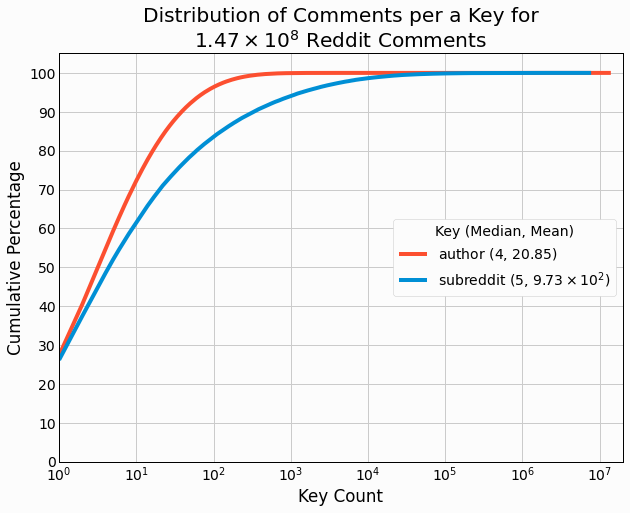

In [24]:
def plot_key_cdf(key_counts, color, label, ax):
    key_count_counts = (key_counts['count']
                        .value_counts()
                        .to_frame()
                        .sort_index()
                        .reset_index()
                        .rename(columns={'index':'key_count'}))
    key_count_counts['cum_frac'] = (key_count_counts['count'].cumsum() / 
                                    key_count_counts['count'].sum())
    key_count_counts['cum_perc'] = key_count_counts['cum_frac'] * 100
   
    def perc(p):
        assert 0 <= p <= 100
        return  key_count_counts['key_count'][key_count_counts['cum_frac'] >= (p/100.0)].iloc[0]
        

    x = key_count_counts
    mn = (x['key_count'] * x['count']).sum() / x['count'].sum()
    x.plot('key_count', 'cum_perc', style='-', ax=ax, color=color,
           label=f'{label} ({int(perc(50))}, {format_number(mn)})')
    #for p in [50]:
    #    pc = perc(p)
    #    ax.plot([x['key_count'].min(), pc], [p, p], '--', color='k', lw=1, zorder=1)
    #    ax.plot([pc, pc], [0, p], '--', color='k', lw=1, zorder=1)


with plt.rc_context({'axes.edgecolor':'k', 'axes.linewidth':1}):
    fig = plt.figure(figsize=(9,7))
    ax = fig.add_subplot(111)
    
    plot_key_cdf(author_count, colors[1], 'author', ax)
    plot_key_cdf(subreddit_count, colors[0], 'subreddit', ax)

    ax.set_xscale('log')
    ax.set_xlim(1, 2e7)
    ax.set_ylim(0, 105)
    ax.set_yticks(np.arange(0, 101, 10))
    ax.set_xlabel('Key Count')
    ax.set_ylabel('Cumulative Percentage')
    ax.set_title(f'Distribution of Comments per a Key for\n{format_number(entries)} Reddit Comments')
    ax.legend(loc='center right', ncol=1, title='Key (Median, Mean)', framealpha=1)

    savefig('reddit_comment_key_count_dist')

# Analyzing Loading

In [25]:
def extract_load_attrs(name):
    key_attr, value_attr, *rest = name.split('_')
    index_rate, partitions, threads = map(int,rest)
    return {'key_attr': key_attr, 'value_attr': value_attr, 'index_rate': index_rate,
            'partitions':partitions, 'threads':threads}

load_results = read_results('load', extract_load_attrs)
load_results.sample(5)

,key_attr,value_attr,index_rate,partitions,threads,results
46,author,id,100,1,4,time writes size 0 0.000000 605760 0 1 1.046787 ...
25,subreddit,id,1,1,4,time writes size 0 0.000000 591631 0 1 1.064001 ...
54,subreddit,id,1,4,8,time writes size 0 0.000000 647356 0 1 1.048615 ...
18,author,id,10,4,2,time writes size 0 0.000000 681119 0 1 1.048744 ...
38,subreddit,id,10,2,4,time writes size 0 0.000000 711281 0 1 1.046689 ...


,count,mean,std,min,25%,50%,75%,max
duration,58.0,3.959267,0.582726,2.713922,3.587866,3.873633,4.220431,5.255999


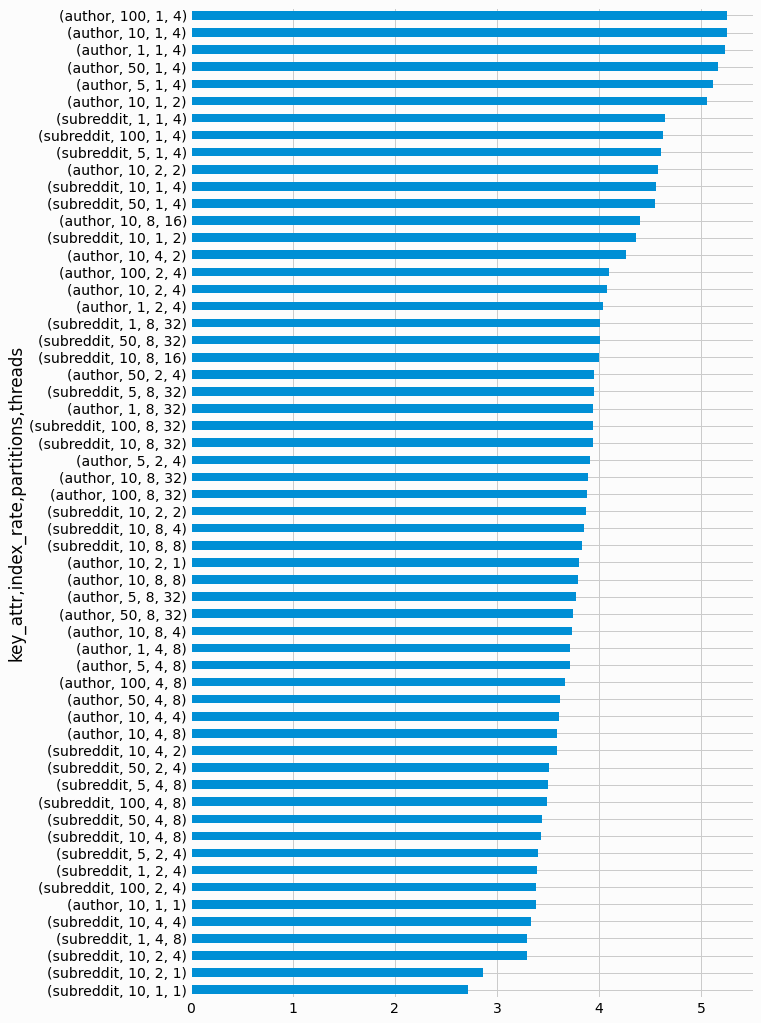

In [26]:
load_results['duration'] = load_results['results'].map(lambda x: x['time'].iloc[-1] - x['time'].iloc[0])
display(load_results['duration'].div(60).describe().to_frame().T)
(load_results
 .set_index(['key_attr', 'index_rate', 'partitions', 'threads'])
 ['duration'].div(60).sort_values()
 .plot.barh(figsize=(9,17)))

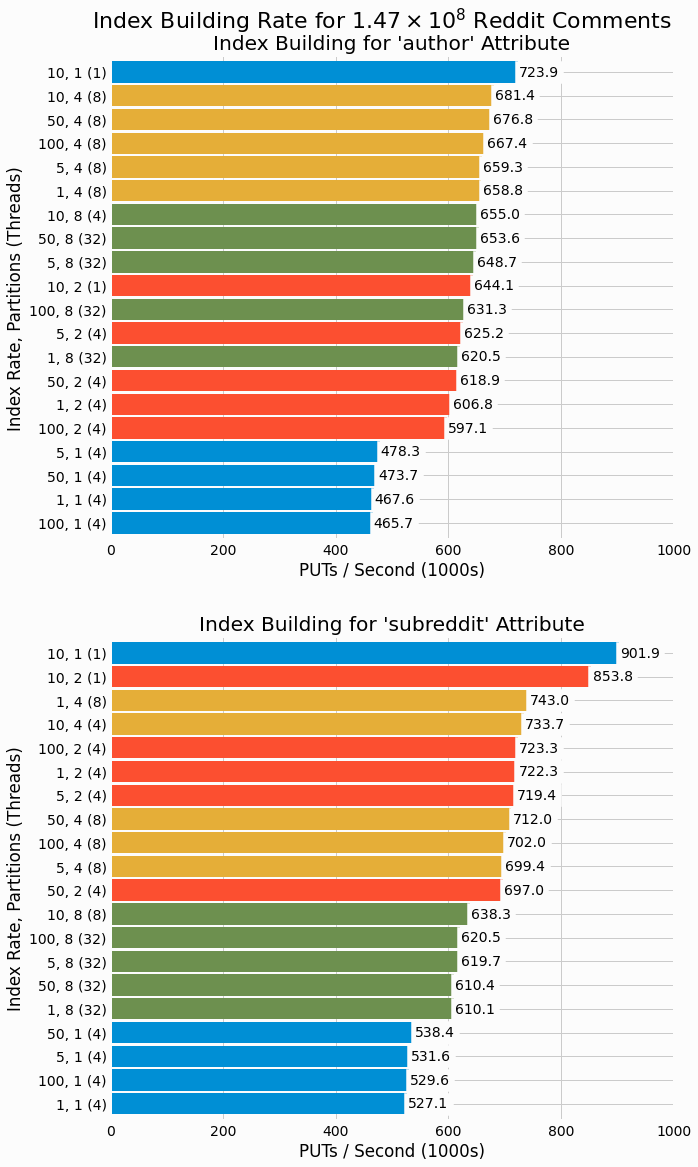

In [27]:
load_results['rate'] = entries / load_results['duration']
fig = plt.figure(figsize=(9,17))

for i,(key_attr, df) in enumerate(load_results.groupby('key_attr')):
    df = (df.groupby(['index_rate', 'partitions'])
          .apply(lambda g: min_duration(g).drop(['index_rate', 'partitions']))
          .sort_values('rate'))
    x = df['rate'].div(1000)
    p = df.reset_index()['partitions']
    ax = fig.add_subplot(2, 1, 1 + i)
    x.plot.barh(color=p.map(dict(zip(sorted(set(p)), colors))), ax=ax, width=0.9)
    add_bar_values(ax, x)
    ax.set_yticklabels(df.reset_index().apply(
        (lambda r: f'{r["index_rate"]}, {r["partitions"]} ({r["threads"]})'), axis=1))
    ax.set_ylabel('Index Rate, Partitions (Threads)')
    ax.set_xlabel('PUTs / Second (1000s)')
    ax.set_title(f"Index Building for '{key_attr}' Attribute")
    ax.set_xlim(0, 1000)
fig.suptitle(f'Index Building Rate for {format_number(entries)} Reddit Comments', size=22)
fig.subplots_adjust(top=0.94)
savefig('load_rate')

In [28]:
load_partition_min_duration = (
    load_results.groupby(['key_attr', 'index_rate', 'partitions'])
    .apply(min_duration)
    .drop(['key_attr', 'index_rate', 'partitions'], axis=1)
)
load_partition_min_duration

value_attr  threads                                                                                              results    duration           rate
key_attr  index_rate partitions                                                                                                                                                    
author    1          1                  id        4             time     writes        size
0      0.000000     588265           0
1      1.047740   ...  314.047159  467618.903750
                     2                  id        4             time     writes        size
0      0.000000     729904           0
1      1.066438   ...  242.028744  606764.244370
                     4                  id        8             time     writes        size
0      0.000000     678166           0
1      1.047545   ...  222.912317  658798.893276
                     8                  id       32             time     writes        size
0      0.000000     558504           0
1      1.051380   ...  236.687220  620457.613706
          5          1                  id        4             time     writes        size
0      0.000000     573488           0
1      1.047887   ...  307.020198  478321.585195
                     2                  id        4             time     writes        size
0      0.000000     725170           0
1      1.051121   ...  234.876377  625241.200970
                     4                  id        8             time     writes        size
0      0.000000     677164           0
1      1.064836   ...  222.741206  659304.988409
                     8                  id       32             time     writes        size
0      0.000000     605242           0
1      1.051227   ...  226.370715  648734.037403
          10         1                  id        1             time     writes        size
0      0.000000     845974           0
1      1.058758   ...  202.869837  723884.784849
                     2                  id        1             time     writes        size
0      0.000000     818365           0
1      1.047541   ...  228.000980  644095.424751
                     4                  id        8             time     writes        size
0      0.000000     693923           0
1      1.056798   ...  215.508463  681432.117381
                     8                  id        4             time     writes        size
0      0.000000     617888           0
1      1.067265   ...  224.200758  655012.897888
          50         1                  id        4             time     writes        size
0      0.000000     584933           0
1      1.047144   ...  310.023589  473687.788023
                     2                  id        4             time     writes        size
0      0.000000     709500           0
1      1.047641   ...  237.300092  618855.167654
                     4                  id        8             time     writes        size
0      0.000000     655283           0
1      1.080788   ...  216.991492  676774.865093
                     8                  id       32             time     writes        size
0      0.000000     603599           0
1      1.062544   ...  224.688482  653591.080950
          100        1                  id        4             time     writes        size
0      0.000000     605760           0
1      1.046787   ...  315.359944  465672.292003
                     2                  id        4             time     writes        size
0      0.000000     699836           0
1      1.047964   ...  245.965937  597051.729795
                     4                  id        8             time     writes        size
0      0.000000     661249           0
1      1.065580   ...  220.037184  667407.140791
                     8                  id       32             time     writes        size
0      0.000000     549270           0
1      1.065755   ...  232.637668  631257.995507
subreddit 1          1                  id        4             time    

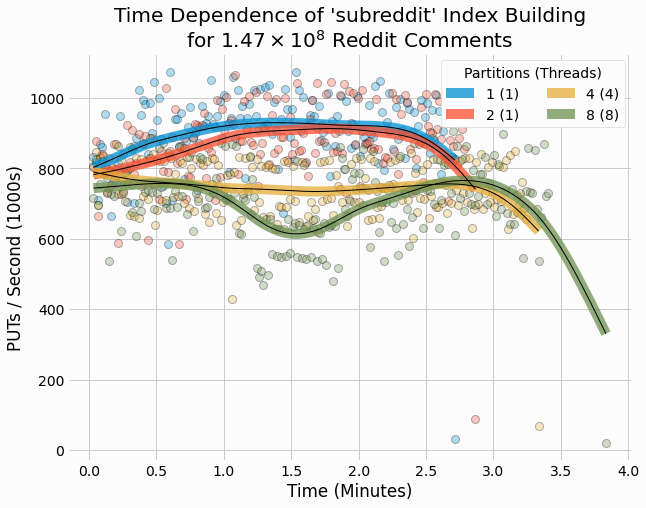

In [29]:
time_plot(compute_rate(load_partition_min_duration.loc['subreddit', 10], 'writes'), 
          y_col='writes', y_scale=1e-3,
          label_func=lambda partitions, row: f'{partitions} ({row["threads"]})')

plt.ylabel('PUTs / Second (1000s)')
plt.legend(loc='upper right', ncol=2, title='Partitions (Threads)', framealpha=1)
plt.xlabel('Time (Minutes)')
plt.title(f'Time Dependence of \'subreddit\' Index Building\nfor {format_number(entries)} Reddit Comments')
savefig('load_time_dependence_subreddit_index10')

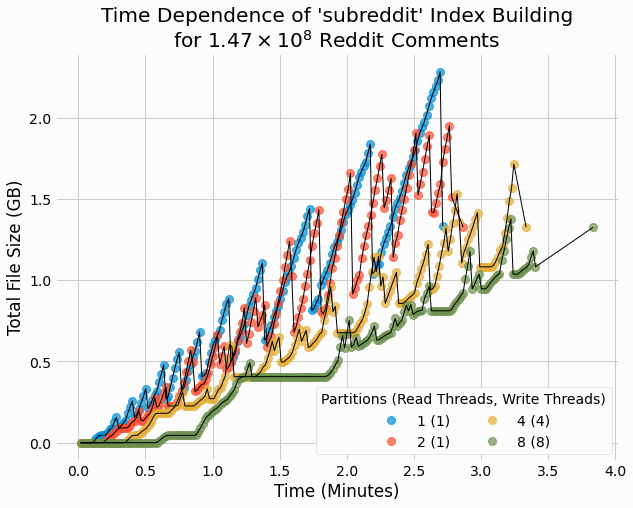

In [30]:
time_plot(load_partition_min_duration.loc['subreddit', 10],
          y_col='size', y_scale=1e-9, spline=False,
          label_func=lambda partitions, row: f'{partitions} ({row["threads"]})')

plt.ylabel('Total File Size (GB)')
plt.legend(loc='lower right', ncol=2, title='Partitions (Read Threads, Write Threads)', framealpha=1)
plt.xlabel('Time (Minutes)')
plt.title(f'Time Dependence of \'subreddit\' Index Building\nfor {format_number(entries)} Reddit Comments')
savefig('load_time_dependence_size_subreddit_index10')

Text(0.5, 1.0, 'Time Dependence of Index Building\nfor 146.9 Million Reddit Comments')

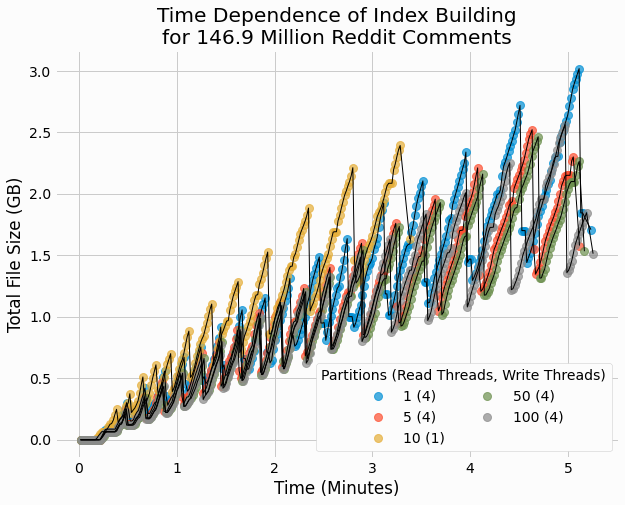

In [31]:
time_plot(load_partition_min_duration.loc['author', ::, 1].reset_index().set_index('index_rate'),
          y_col='size', y_scale=1e-9, spline=False,
          label_func=lambda index_rate, row: f'{index_rate} ({row["threads"]})')

plt.ylabel('Total File Size (GB)')
plt.legend(loc='lower right', ncol=2, title='Partitions (Read Threads, Write Threads)', framealpha=1)
plt.xlabel('Time (Minutes)')
plt.title(f'Time Dependence of Index Building\nfor {entries/1e6:.1f} Million Reddit Comments')
#savefig('doc_load_time_dependence_size')

# Analyzing Get

In [32]:
!ls $results_base_dir/get

results.jsonl  specs.jsonl


In [33]:
intermediate_get_path = intermediate_base_dir + '/get_results.p'


def convert_stats(stats):
    if not stats:
        return pd.DataFrame([], columns=['floor', 'count', 't_digest'])
    stats = pd.DataFrame(stats)
    if 'tDigtest' in stats.columns:
        stats = stats.rename(columns={'tDigtest':'tDigest'})
    stats['t_digest'] = stats['tDigest'].map(read_tdigest)
    stats = stats.drop(['tDigest'], axis=1)
    return stats[['floor', 'count', 't_digest']]

def combine_stats(stats):
    acc_floor = defaultdict(list)
    for floor_stats in stats:
        if len(floor_stats):
            for _, stat in floor_stats.iterrows():
                acc_floor[stat['floor']].append(stat['t_digest'])
    return pd.DataFrame([{'floor':f, 't_digest': tdigest_merge(tds)}
                         for f, tds in acc_floor.items()])
    
    
def aggregate_results(df):
    df['time'] = (df['nano_time'] - df['nano_time'].min()) / 1e9
    df = df.drop(['nano_time', 'spec_id'], axis=1)
    df = df.sort_values('time')
    df['stats'] = df['stats'].map(convert_stats)
    return pd.Series({
        'results': df,
        'duration': df['time'].iloc[-1],
        'get_keys': df['get_keys'].iloc[-1],
        'get_values': df['get_values'].iloc[-1],
        'file_size': df['file_size'].iloc[-1],
        'total_stats': combine_stats(df['stats'])
    })

if 'get_results' in globals():
    print('skipping time consuming loading of get_results since it already exists')
elif os.path.exists(intermediate_get_path):
    print('loading get_results from disk')
    get_results = pd.read_pickle(intermediate_get_path)
else:
    print('computing get_results from raw data. this may take a while')
    get_specs = pd.read_json(results_base_dir + '/get/specs.jsonl', lines=True)
    get_specs = pd.concat([get_specs.drop('spec', axis=1),
                           pd.DataFrame(list(get_specs['spec']), index=get_specs.index)], axis=1)
    print(len(get_specs))
    
    get_results_entries = pd.read_json(results_base_dir + '/get/results.jsonl', lines=True, convert_dates=False)
    print(len(get_results_entries))
    get_results_entries.sample(5)

    get_results = get_results_entries.groupby('spec_id').progress_apply(aggregate_results)
    get_results = pd.concat([get_specs.set_index('id'), get_results], axis=1)

get_results.sample(5)

loading get_results from disk


,created_at,events,last_modified,status,partitions,duration_seconds,report_frequency_seconds,key_attr,trial_index,index_rate,thread_count,results,duration,get_keys,get_values,get_key_rate,get_value_rate,file_size,total_stats
9c744102-9c37-11ea-8269-00155d010301,2020-05-22 14:22:05.022130,"[{'msg': 'starting', 'hostname': 'ec2-52-12-239-150.us-west-2.compute.amazonaws.com', 'time': '2...",2020-05-22T15:57:45.660763,succeeded,1,300,10,author,0,5,4,...,299.999048,49224709,994764597,164082.884056,3.315893e+06,1438207140,floor ...
9a11b180-9c37-11ea-8269-00155d010301,2020-05-22 14:22:02.743209,"[{'msg': 'starting', 'hostname': 'ec2-54-218-108-252.us-west-2.compute.amazonaws.com', 'time': '...",2020-05-22T15:32:40.536330,succeeded,4,300,10,author,0,10,4,...,299.999387,48685855,1018834052,162286.515044,3.396120e+06,1425875332,floor ...
9c744118-9c37-11ea-8269-00155d010301,2020-05-22 14:22:06.758621,"[{'msg': 'starting', 'hostname': 'ec2-52-12-255-39.us-west-2.compute.amazonaws.com', 'time': '20...",2020-05-22T16:37:42.343896,succeeded,4,300,10,subreddit,0,10,8,...,300.314867,12509958,12116640437,41656.139531,4.034646e+07,1324156278,floor ...
9dace35a-9c37-11ea-8269-00155d010301,2020-05-22 14:22:08.006930,"[{'msg': 'starting', 'hostname': 'ec2-52-12-239-150.us-west-2.compute.amazonaws.com', 'time': '2...",2020-05-22T15:42:38.695829,succeeded,1,300,10,author,0,5,16,...,299.999145,166411550,3483286357,554706.747413,1.161099e+07,1438207140,floor ...
9b491b24-9c37-11ea-8269-00155d010301,2020-05-22 14:22:04.785900,"[{'msg': 'starting', 'hostname': 'ec2-54-186-78-161.us-west-2.compute.amazonaws.com', 'time': '2...",2020-05-22T15:57:50.381118,succeeded,1,300,10,author,0,100,8,...,300.275705,46723763,967967797,155602.875208,3.223597e+06,1415532963,floor ...


## Analyzie High-Level GET Performance

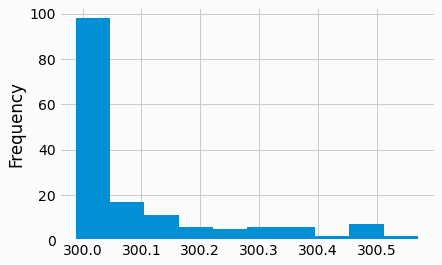

In [34]:
get_results['duration'].plot.hist()

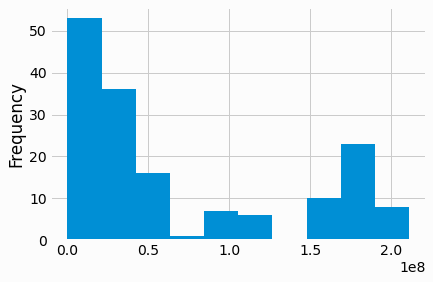

In [35]:
get_results['get_keys'].plot.hist()

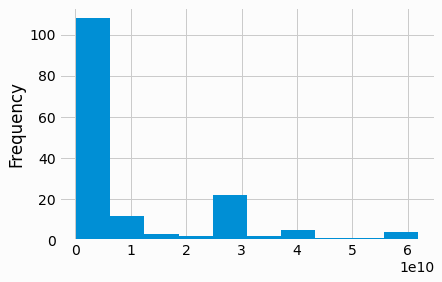

In [36]:
get_results['get_values'].plot.hist()

,count,mean,std,min,25%,50%,75%,max
get_key_rate,160.0,230.539126,238.236827,0.842407,40.01403,103.926443,508.029044,703.454866


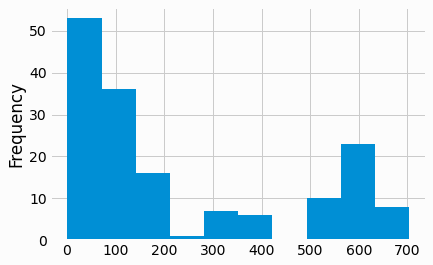

In [37]:
get_results['get_key_rate'] = get_results['get_keys'] / get_results['duration']
display(get_results['get_key_rate'].div(1e3).describe().to_frame().T)
get_results['get_key_rate'].div(1e3).plot.hist()

,count,mean,std,min,25%,50%,75%,max
get_value_rate,160.0,35.758591,47.926021,0.401781,6.318986,12.871413,41.329132,205.671415


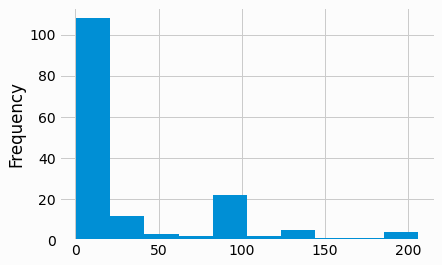

In [38]:
get_results['get_value_rate'] = get_results['get_values'] / get_results['duration']
display(get_results['get_value_rate'].div(1e6).describe().to_frame().T)
get_results['get_value_rate'].div(1e6).plot.hist()

count          mean  std           min           25%           50%           75%           max
key_attr  partitions index_rate                                                                                                
subreddit 1          100          10.0  1.323917e+09  0.0  1.323917e+09  1.323917e+09  1.323917e+09  1.323917e+09  1.323917e+09
                     50           10.0  1.323945e+09  0.0  1.323945e+09  1.323945e+09  1.323945e+09  1.323945e+09  1.323945e+09
          8          10           10.0  1.324152e+09  0.0  1.324152e+09  1.324152e+09  1.324152e+09  1.324152e+09  1.324152e+09
          4          10           10.0  1.324156e+09  0.0  1.324156e+09  1.324156e+09  1.324156e+09  1.324156e+09  1.324156e+09
          2          10           10.0  1.324161e+09  0.0  1.324161e+09  1.324161e+09  1.324161e+09  1.324161e+09  1.324161e+09
          1          10           10.0  1.324165e+09  0.0  1.324165e+09  1.324165e+09  1.324165e+09  1.324165e+09  1.324165e+09
                     5            10.0  1.324441e+09  0.0  1.324441e+09  1.324441e+09  1.324441e+09  1.324441e+09  1.324441e+09
                     1            10.0  1.326648e+09  0.0  1.326648e+09  1.326648e+09  1.326648e+09  1.326648e+09  1.326648e+09
author    1          100          10.0  1.415533e+09  0.0  1.415533e+09  1.415533e+09  1.415533e+09  1.415533e+09  1.415533e+09
                     50           10.0  1.416725e+09  0.0  1.416725e+09  1.416725e+09  1.416725e+09  1.416725e+09  1.416725e+09
          8          10           10.0  1.425694e+09  0.0  1.425694e+09  1.425694e+09  1.425694e+09  1.425694e+09  1.425694e+09
          4          10           10.0  1.425875e+09  0.0  1.425875e+09  1.425875e+09  1.425875e+09  1.425875e+09  1.425875e+09
          2          10           10.0  1.426138e+09  0.0  1.426138e+09  1.426138e+09  1.426138e+09  1.426138e+09  1.426138e+09
          1          10           10.0  1.426274e+09  0.0  1.426274e+09  1.426274e+09  1.426274e+09  1.426274e+09  1.426274e+09
                     5            10.0  1.438207e+09  0.0  1.438207e+09  1.438207e+09  1.438207e+09  1.438207e+09  1.438207e+09
                     1            10.0  1.533700e+09  0.0  1.533700e+09  1.533700e+09  1.533700e+09  1.533700e+09  1.533700e+09

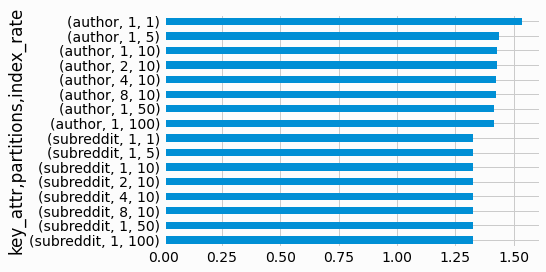

In [39]:

size_stats = (
    get_results
    .groupby(['key_attr', 'partitions', 'index_rate'])
    ['file_size'].describe()
    .sort_values('50%'))
display(size_stats)
size_stats['50%'].div(1e9).plot.barh()

In [40]:
(
    get_results
    .groupby(['key_attr','index_rate'])
    ['file_size'].describe()
    .sort_values('50%'))

count          mean            std           min           25%           50%           75%           max
key_attr  index_rate                                                                                                          
subreddit 100          10.0  1.323917e+09       0.000000  1.323917e+09  1.323917e+09  1.323917e+09  1.323917e+09  1.323917e+09
          50           10.0  1.323945e+09       0.000000  1.323945e+09  1.323945e+09  1.323945e+09  1.323945e+09  1.323945e+09
          10           40.0  1.324159e+09    4807.370750  1.324152e+09  1.324155e+09  1.324159e+09  1.324162e+09  1.324165e+09
          5            10.0  1.324441e+09       0.000000  1.324441e+09  1.324441e+09  1.324441e+09  1.324441e+09  1.324441e+09
          1            10.0  1.326648e+09       0.000000  1.326648e+09  1.326648e+09  1.326648e+09  1.326648e+09  1.326648e+09
author    100          10.0  1.415533e+09       0.000000  1.415533e+09  1.415533e+09  1.415533e+09  1.415533e+09  1.415533e+09
          50           10.0  1.416725e+09       0.000000  1.416725e+09  1.416725e+09  1.416725e+09  1.416725e+09  1.416725e+09
          10           40.0  1.425995e+09  228354.395802  1.425694e+09  1.425830e+09  1.426007e+09  1.426172e+09  1.426274e+09
          5            10.0  1.438207e+09       0.000000  1.438207e+09  1.438207e+09  1.438207e+09  1.438207e+09  1.438207e+09
          1            10.0  1.533700e+09       0.000000  1.533700e+09  1.533700e+09  1.533700e+09  1.533700e+09  1.533700e+09

In [41]:


def filter_get_results(key_attr=None, partitions=None, index_rate=None, thread_count=None):
    attr_exprs =  [('key_attr', key_attr),
                   ('partitions', partitions),
                   ('index_rate', index_rate),
                   ('thread_count', thread_count)]
    masks = [create_mask(get_results, attr, expr) for attr,expr in attr_exprs]
    mask = combine_masks(masks)
    if mask is None:
        return get_results
    return get_results[mask]
    

In [42]:
def plot_thread_dependence(ax, df, group_col, y_col='get_key_rate', y_scale=1e-3):
    for partitions, x in df.groupby(group_col):
        x = x.copy()
        x[y_col] *= y_scale
        x = x.sort_values('thread_count')
        x.plot('thread_count', y_col, style='o-', label=str(partitions), ax=ax, ms=10)
        
    ts = sorted(set(x['thread_count']) - {2})
    ax.set_xticks(ts)
    ax.set_xlabel('Concurrent Reading Threads')
    

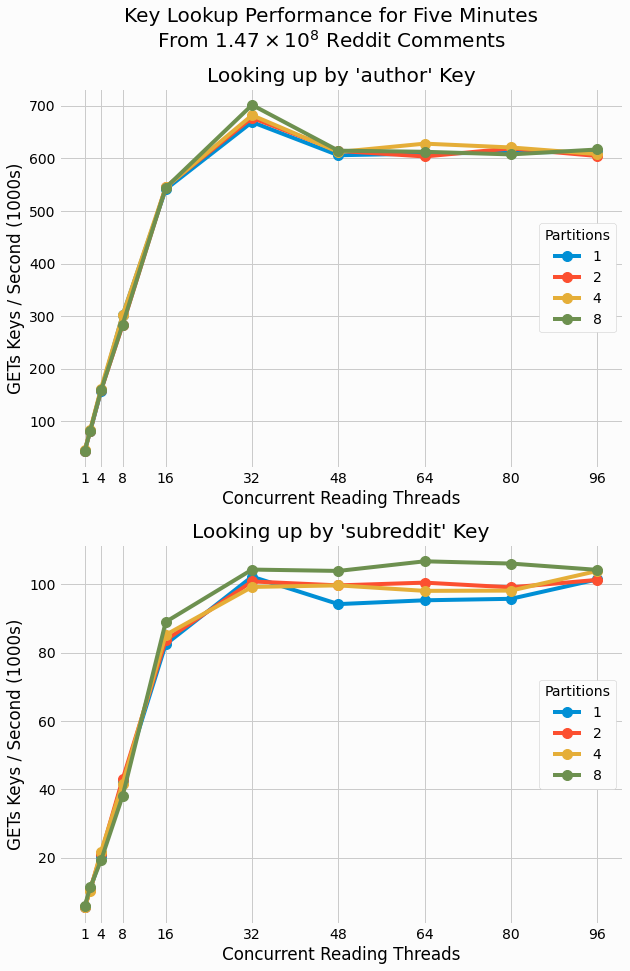

In [43]:
fig = plt.figure(figsize=(9, 14))
ax1 = fig.add_subplot(2, 1, 1)
plot_thread_dependence(ax1, filter_get_results(key_attr='author', index_rate=10), 'partitions')
ax1.set_title('Looking up by \'author\' Key')
ax2 = fig.add_subplot(2, 1, 2)
ax2.set_title('Looking up by \'subreddit\' Key')
plot_thread_dependence(ax2, filter_get_results(key_attr='subreddit', index_rate=10), 'partitions')
for ax in [ax1, ax2]:
    ax.set_ylabel('GETs Keys / Second (1000s)')
    ax.legend(loc='center right', ncol=1, title='Partitions', framealpha=1)

fig.suptitle(f'Key Lookup Performance for Five Minutes\nFrom {format_number(entries)} Reddit Comments',
            size=20)
fig.subplots_adjust(top=0.90)
savefig('get_key_rate_partitions')

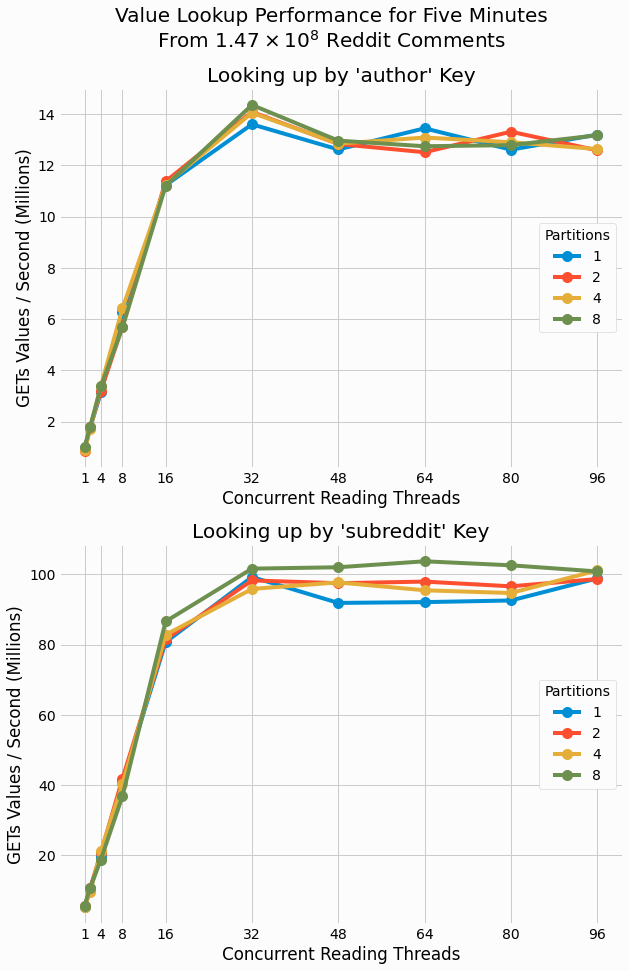

In [44]:
fig = plt.figure(figsize=(9, 14))
ax1 = fig.add_subplot(2, 1, 1)
plot_thread_dependence(ax1, filter_get_results(key_attr='author', index_rate=10), 'partitions',
                       y_col='get_value_rate', y_scale=1e-6)
ax1.set_title('Looking up by \'author\' Key')
ax2 = fig.add_subplot(2, 1, 2)
ax2.set_title('Looking up by \'subreddit\' Key')
plot_thread_dependence(ax2, filter_get_results(key_attr='subreddit', index_rate=10), 'partitions',
                       y_col='get_value_rate', y_scale=1e-6)

for ax in [ax1, ax2]:
    ax.set_ylabel('GETs Values / Second (Millions)')
    ax.legend(loc='center right', ncol=1, title='Partitions', framealpha=1)

fig.suptitle(f'Value Lookup Performance for Five Minutes\nFrom {format_number(entries)} Reddit Comments',
            size=20)
fig.subplots_adjust(top=0.90)
savefig('get_value_rate_partitions')

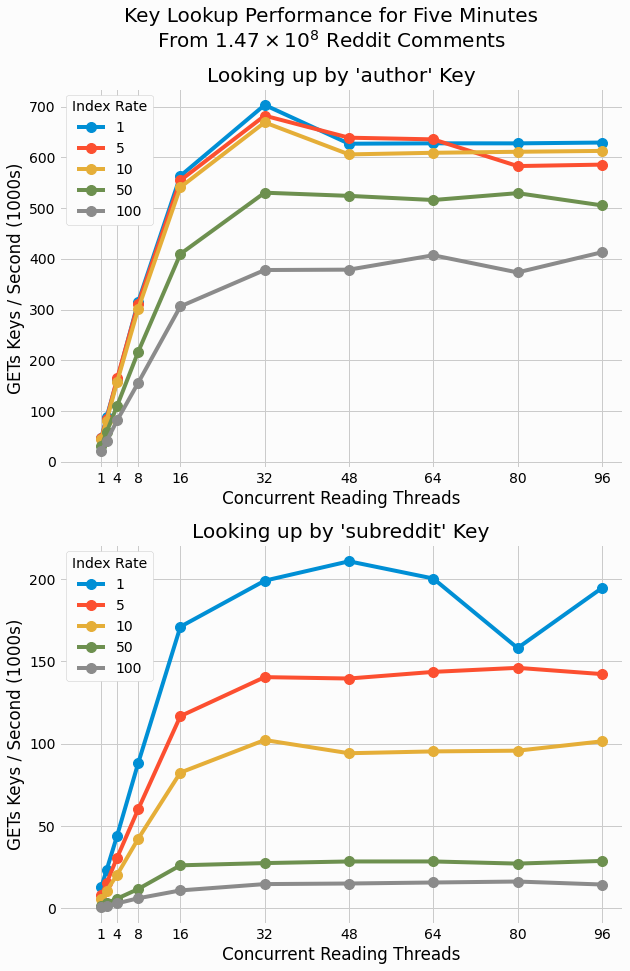

In [45]:
fig = plt.figure(figsize=(9, 14))
ax1 = fig.add_subplot(2, 1, 1)
plot_thread_dependence(ax1, filter_get_results(key_attr='author', partitions=1), 'index_rate')
ax1.set_title('Looking up by \'author\' Key')
ax2 = fig.add_subplot(2, 1, 2)
ax2.set_title('Looking up by \'subreddit\' Key')
plot_thread_dependence(ax2, filter_get_results(key_attr='subreddit', partitions=1), 'index_rate')
for ax in [ax1, ax2]:
    ax.set_ylabel('GETs Keys / Second (1000s)')
    ax.legend(loc='upper left', ncol=1, title='Index Rate', framealpha=1)
    ax.set_xlim(-7, 100)

fig.suptitle(f'Key Lookup Performance for Five Minutes\nFrom {format_number(entries)} Reddit Comments',
            size=20)
fig.subplots_adjust(top=0.90)
savefig('get_key_rate_index_rate')

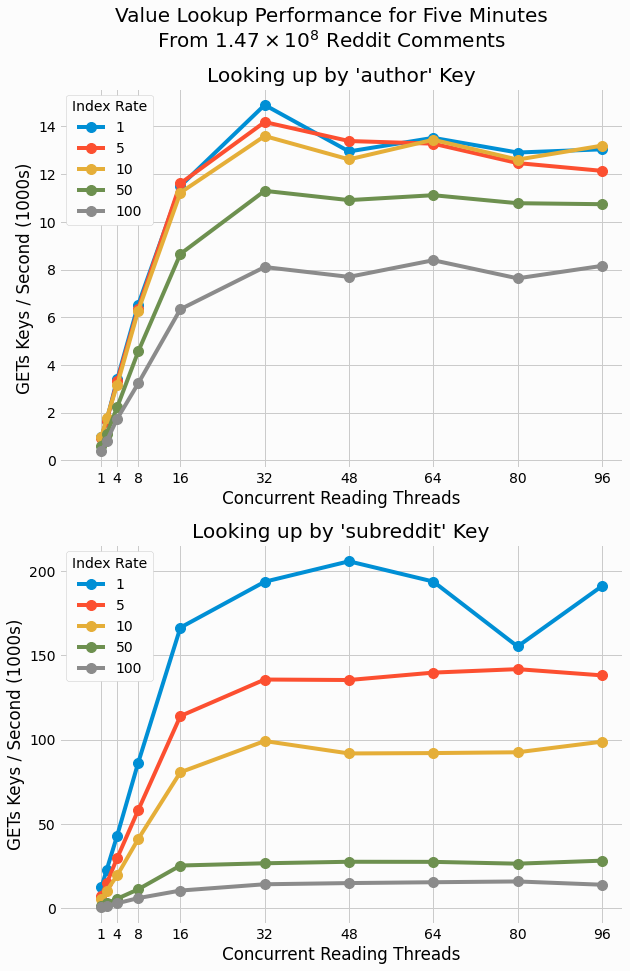

In [46]:
fig = plt.figure(figsize=(9, 14))
ax1 = fig.add_subplot(2, 1, 1)
plot_thread_dependence(ax1, filter_get_results(key_attr='author', partitions=1), 'index_rate',
                        y_col='get_value_rate', y_scale=1e-6)

ax1.set_title('Looking up by \'author\' Key')
ax2 = fig.add_subplot(2, 1, 2)
ax2.set_title('Looking up by \'subreddit\' Key')
plot_thread_dependence(ax2, filter_get_results(key_attr='subreddit', partitions=1), 'index_rate',
                        y_col='get_value_rate', y_scale=1e-6)

for ax in [ax1, ax2]:
    ax.set_ylabel('GETs Keys / Second (1000s)')
    ax.legend(loc='upper left', ncol=1, title='Index Rate', framealpha=1)
    ax.set_xlim(-7, 100)

fig.suptitle(f'Value Lookup Performance for Five Minutes\nFrom {format_number(entries)} Reddit Comments',
            size=20)
fig.subplots_adjust(top=0.90)
savefig('get_value_rate_index_rate')

## Analyze Get Latency

In [49]:
percentiles = [0, 10, 25, 50, 75, 90, 95, 99, 99.9, 100]

def compute_combined_bin_latency_percentiles(df):
    t_digest = tdigest_merge(df['t_digest'])
    return pd.Series({p:t_digest.percentile(p) for p in percentiles})

get_combined_stats = (
    get_results
    .set_index(['key_attr', 'partitions', 'index_rate', 'thread_count'])
    ['total_stats']
    .progress_map(compute_combined_bin_latency_percentiles))

get_combined_stats = pd.DataFrame(list(get_combined_stats), index=get_combined_stats.index).reset_index()

get_combined_stats.sample(5)

100%|██████████| 160/160 [00:32<00:00,  4.95it/s]


,key_attr,partitions,index_rate,thread_count,0.0,10.0,25.0,50.0,75.0,90.0,95.0,99.0,99.9,100.0
90,author,8,10,96,0.015315,0.025132,0.031483,0.036760,0.041769,0.049813,0.060528,0.433736,3.871521,1369.054565
41,author,4,10,2,0.013644,0.019038,0.019879,0.021167,0.023359,0.027547,0.032491,0.046195,0.179885,863.764343
145,subreddit,4,10,48,0.013974,0.023191,0.025757,0.035557,0.100866,0.431093,1.036793,6.956684,43.702538,1826.779053
119,subreddit,1,100,80,0.016089,0.036803,0.067057,0.572040,2.266323,13.092631,27.154821,66.097302,189.133496,3312.407715
43,author,1,100,1,0.013330,0.021509,0.028551,0.040311,0.052942,0.065307,0.074020,0.095956,0.164257,315.765594


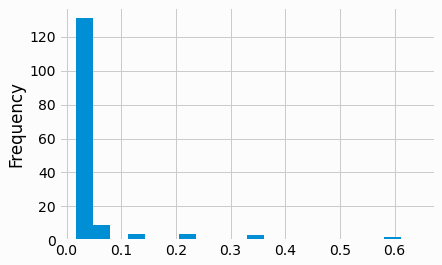

In [50]:
get_combined_stats[50.0].plot.hist(bins=20)

In [51]:
def filter_get_combined_stats(key_attr=None, partitions=None, index_rate=None, thread_count=None):
    attr_exprs =  [('key_attr', key_attr),
                   ('partitions', partitions),
                   ('index_rate', index_rate),
                   ('thread_count', thread_count)]
    masks = [create_mask(get_combined_stats, attr, expr) for attr,expr in attr_exprs]
    mask = combine_masks(masks)
    if mask is None:
        return get_combined_stats
    return get_combined_stats[mask]

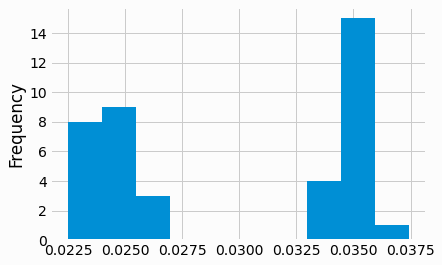

In [52]:
filter_get_combined_stats('subreddit', index_rate=10)[50.0].plot.hist()

In [57]:
latency_outlier_markers = [
    (90.0, '>'),
    (99.9, '^'),
    (100.0, '*')
]

def plot_latency_thread_dependency(ax, df, group_col, legend_label):
    for color, (group_val, group) in zip(colors, df.groupby(group_col)):
        group = group.sort_values('thread_count')
        ts = group['thread_count']
        med = group[50.0]
        p25 = group[25.0]
        p75 = group[75.0]
        
        ax.errorbar(ts, med, [med - p25, p75 - med], marker='o', ls='-', label=str(group_val),
                    ms=5, color=color, elinewidth=2)
        
        for p, m in latency_outlier_markers:
            ax.plot(ts, group[p], color=color, ls='None', marker=m, ms=10)
            
    ax.set_yscale('log')
        
    ts = sorted(set(group['thread_count']) - {2})
    ax.set_xticks(ts)
    ax.errorbar([0], [1], [1], color='k', marker='o', ms=5, elinewidth=2, label='Median &\nInterquartile')
    for p, m in latency_outlier_markers:
        ax.plot([0], [1], color='k', ls='None', marker=m, ms=10, label=f'{p}%', zorder=10)
    ax.set_xlim(0, 140)
    
    ax.set_xlabel('Concurrent Reading Threads')
    ax.set_ylabel('Get Latency (ms)')

    handles, labels = ax.get_legend_handles_labels()
    handles, labels = zip(*sorted(zip(handles, labels), key=lambda p: (not p[1].isdigit(), '%' in p[1])))
    ax.legend(handles, labels, loc='upper right', ncol=1, title=legend_label, framealpha=1)


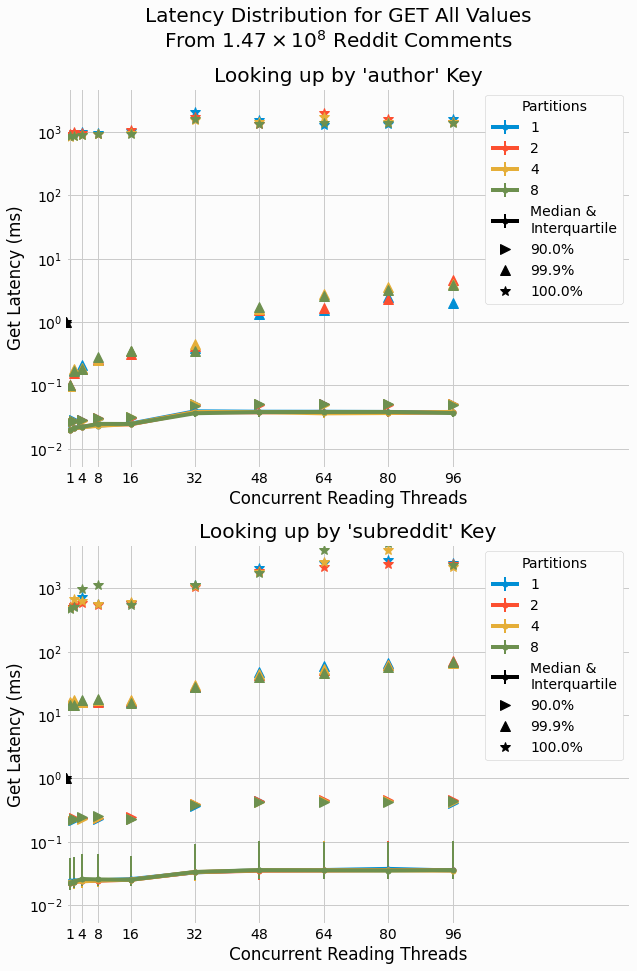

In [58]:
fig = plt.figure(figsize=(9, 14))
for i, key_attr in enumerate(['author', 'subreddit']):
    ax = fig.add_subplot(2, 1, i+1)
    plot_latency_thread_dependency(ax, filter_get_combined_stats(key_attr, index_rate=10),
                                   'partitions', 'Partitions')
    ax.set_title('Looking up by \'' + key_attr + '\' Key')
    ax.set_ylim(5e-3, 5e3)

fig.suptitle(f'Latency Distribution for GET All Values\nFrom {format_number(entries)} Reddit Comments', size=20)
fig.subplots_adjust(top=0.90)


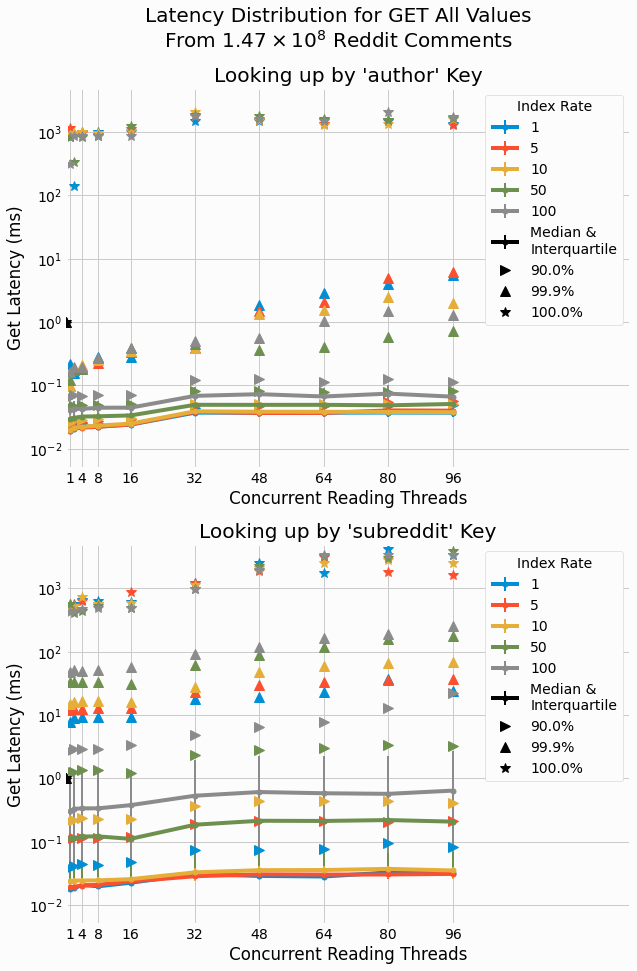

In [59]:
fig = plt.figure(figsize=(9, 14))
for i, key_attr in enumerate(['author', 'subreddit']):
    ax = fig.add_subplot(2, 1, i+1)
    plot_latency_thread_dependency(ax, filter_get_combined_stats(key_attr, partitions=1),
                                   'index_rate', 'Index Rate')
    ax.set_title('Looking up by \'' + key_attr + '\' Key')
    ax.set_ylim(5e-3, 5e3)

fig.suptitle(f'Latency Distribution for GET All Values\nFrom {format_number(entries)} Reddit Comments', size=20)
fig.subplots_adjust(top=0.90)
savefig('get_latency_index_rate')

In [60]:
def get_entry(**kwds):
    df = filter_get_results(**kwds)
    assert len(df) == 1, len(df)
    return df.iloc[0]

column_labels = {
    'key_attr': 'Key',
    'partitions': 'Partitions',
    'index_rate': 'Index Rate',
    'thread_count': 'Threads'
}

def trial_spec_str(trial, columns=None):
    return ' '.join('='.join([column_labels[column], str(trial[column])])
                    for column in (columns or column_labels.keys()))
        
        
def plot_binned_latency(ax, trial):    
    stats = trial['total_stats']
    for _, row in stats.iterrows():
        plot_centroids_cdf(compute_centroids(row['t_digest']), f'{row["floor"]:,}', ax)


    plot_centroids_cdf(compute_centroids(tdigest_merge(stats['t_digest'])), 'Combined', ax, color='k', ls='--')
    ax.set_xscale('log')
    ax.set_xlabel('Latency (ms)')
    ax.set_ylabel('Cumulative Fraction')
    ax.set_xlim(1e-2, 5e8)
    ax.set_xticks(10 ** np.arange(-2, 4.1, 1.0))
    ax.set_yticks(np.arange(0, 1.01, 0.1))
    ax.legend(loc='upper right', ncol=1, title='Bin Floor (Count Observations, Median)', framealpha=1,
              prop={'family': 'monospace'})

def plot_binned_latency_for_key_attrs(partitions, index_rate, thread_count):
    attrs = dict(partitions=partitions, index_rate=index_rate, thread_count=thread_count)
    fig = plt.figure(figsize=(11,14))
    ax1 = fig.add_subplot(2, 1, 1)
    plot_binned_latency(ax1, get_entry(key_attr='author', **attrs))
    ax1.set_title(f'Key=\'author\'')
    ax2 = fig.add_subplot(2, 1, 2)
    plot_binned_latency(ax2, get_entry(key_attr='subreddit', **attrs))
    ax2.set_title(f'Key=\'subreddit\'')
    spec = trial_spec_str(attrs, ["partitions", "index_rate", "thread_count"])
    fig.suptitle(f'Latency for GET All Values, Binned by Value Count\n{spec}', size=20)
    fig.subplots_adjust(top=0.9)


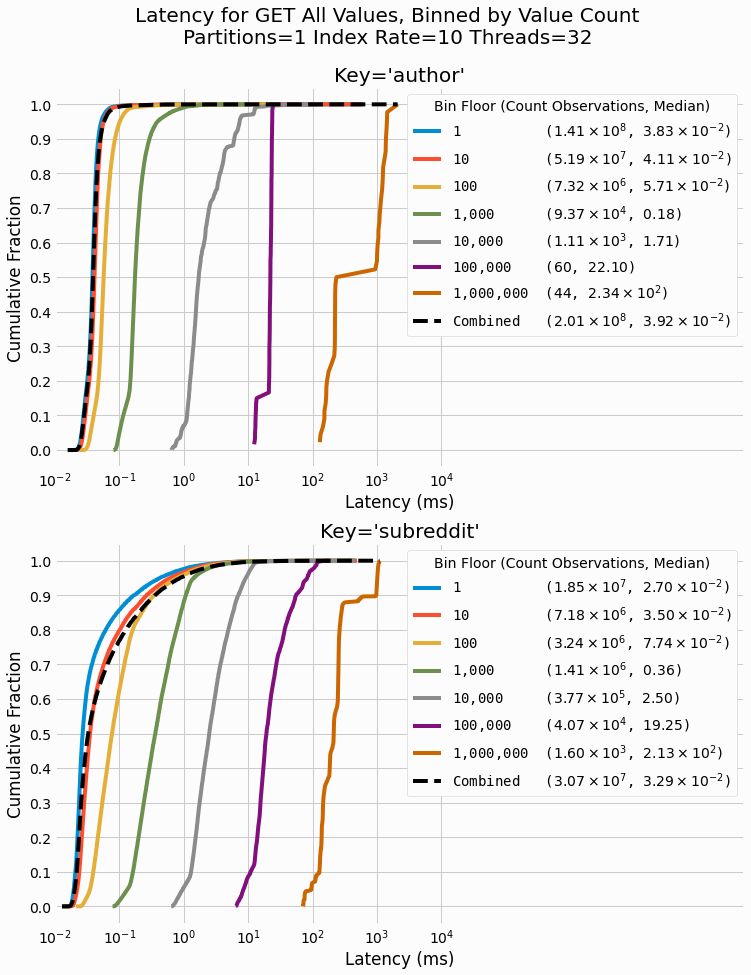

In [61]:
plot_binned_latency_for_key_attrs(1, 10, 32)

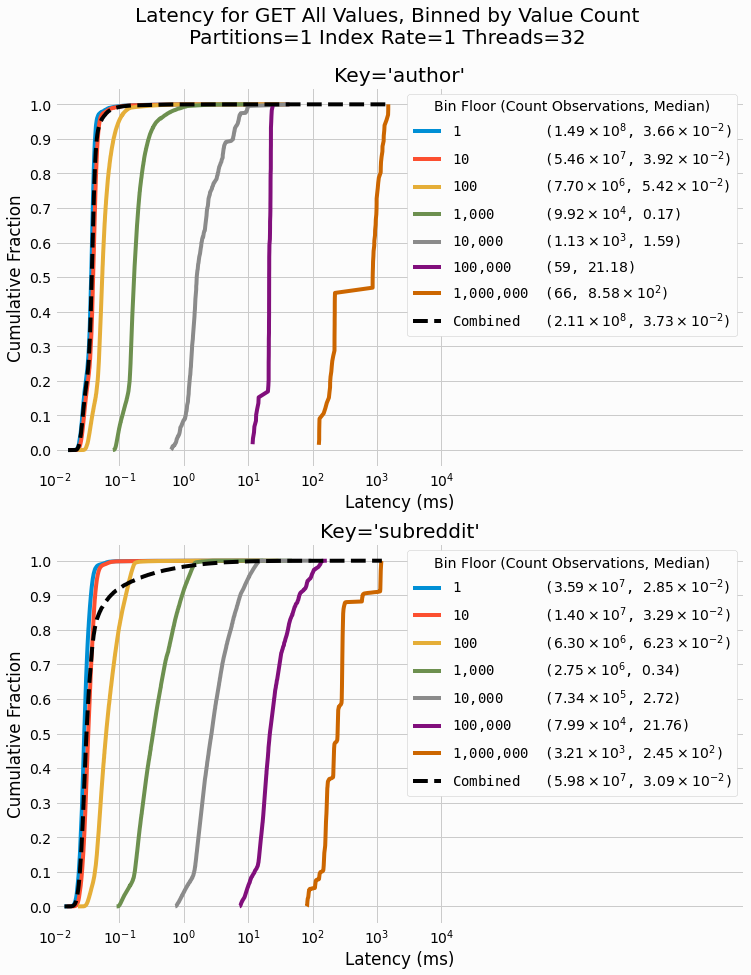

In [62]:
plot_binned_latency_for_key_attrs(1, 1, 32)

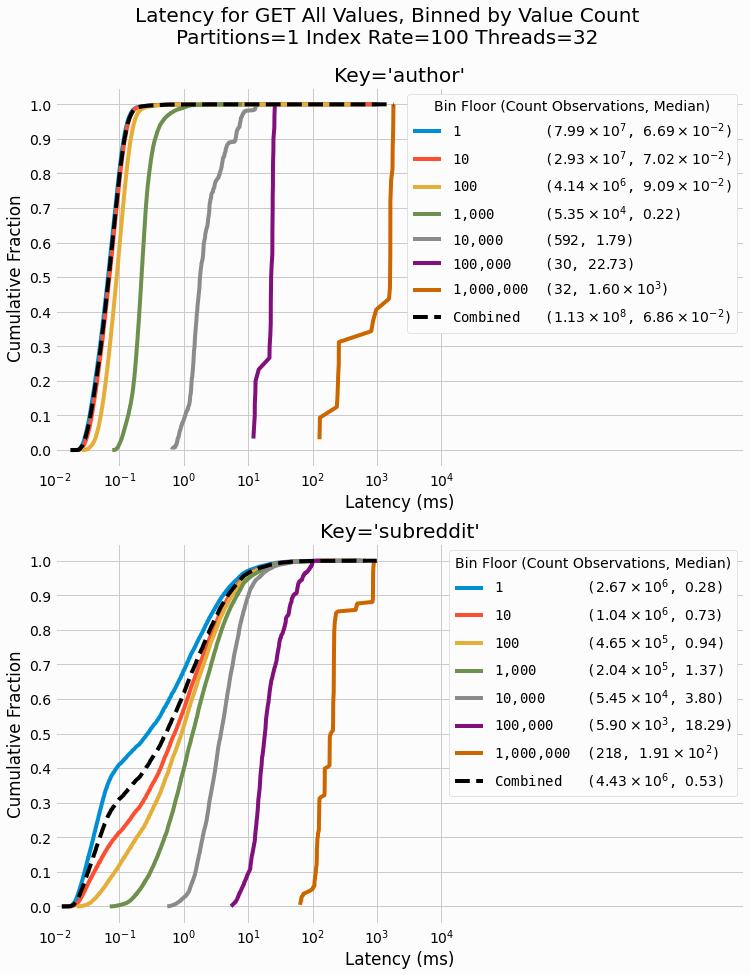

In [63]:
plot_binned_latency_for_key_attrs(1, 100, 32)

In [64]:

def plot_latency_time_dependence(trial):
    df = trial['results']
    df = df.iloc[1:-1:]
    t = df['time'] / 60.0


    stats = df['stats'].map(compute_combined_bin_latency_percentiles)
    stats = pd.DataFrame(list(stats), index=stats.index).reset_index()
    stats

    fig = plt.figure(figsize=(9,7))
    ax = fig.add_subplot(111)

    med = stats[50.0]
    p25 = stats[25.0]
    p75 = stats[75.0]

    ax.errorbar(t, med, [med - p25, p75 - med], marker='o', ls='-',
                ms=5, elinewidth=2, lw=2, label='Median &\nInterquartile')

    for p, m in latency_outlier_markers:
        ax.plot(t, stats[p], ls='None', marker=m, ms=10, label=f'{p}%')
    ax.set_yscale('log')
    ax.set_ylabel('Latency (ms)')
    ax.set_xlabel('Time (Minutes)')
    ax.set_xlim(0, 7)
    ax.set_xticks(np.arange(0, 5.1, 1))

    spec = trial_spec_str(trial)
    ax.set_title(f'Latency for GET All Values Over Time\n{spec}')

    handles, labels = ax.get_legend_handles_labels()
    handles, labels = zip(*sorted(zip(handles, labels), key=lambda p: (not p[1].isdigit(), '%' in p[1])))
    ax.legend(handles, labels, loc='upper right', ncol=1, framealpha=1, title='Percentiles')
    


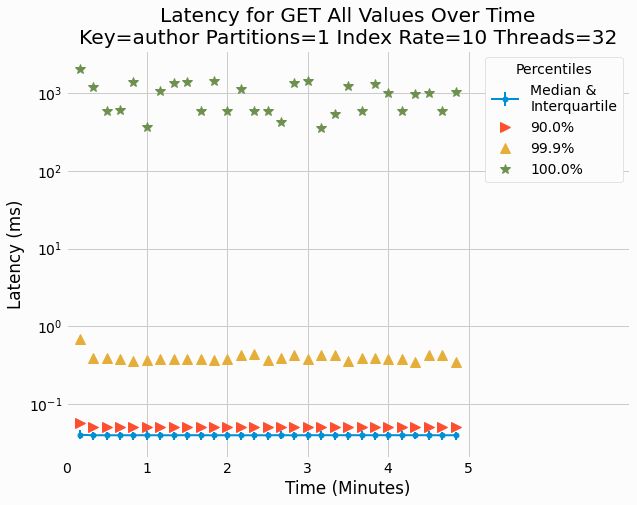

In [65]:
plot_latency_time_dependence(get_entry(key_attr='author', partitions=1, index_rate=10, thread_count=32))

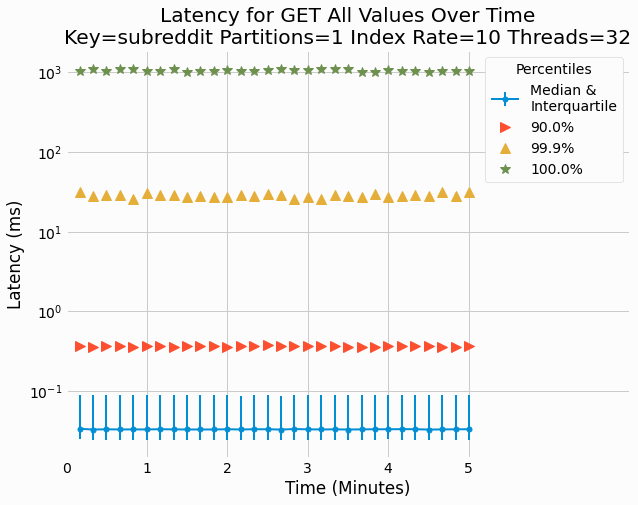

In [66]:
plot_latency_time_dependence(get_entry(key_attr='subreddit', partitions=1, index_rate=10, thread_count=32))

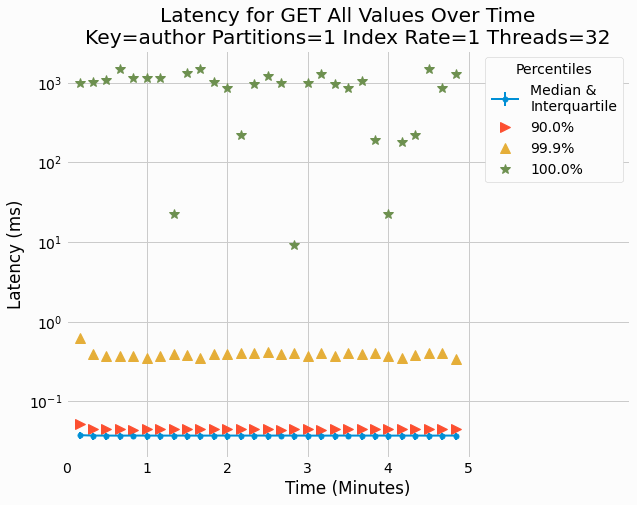

In [67]:
plot_latency_time_dependence(get_entry(key_attr='author', partitions=1, index_rate=1, thread_count=32))

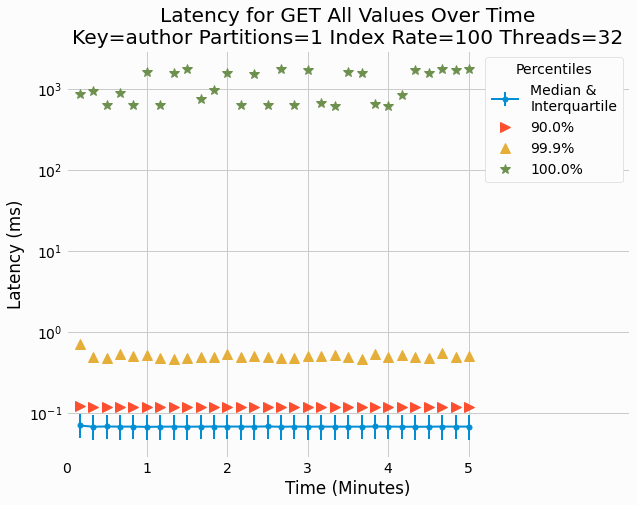

In [68]:
plot_latency_time_dependence(get_entry(key_attr='author', partitions=1, index_rate=100, thread_count=32))